In [1]:
import copy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader

from skpm import event_logs

from ppm.datasets import ContinuousTraces
from ppm.datasets.event_logs import EventFeatures, EventLog, EventTargets
from ppm.datasets.utils import continuous
from ppm.models import NextEventPredictor
from ppm.engine.utils import load_checkpoint

from utils import parse_args, get_model_config, prepare_data


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1


# Prepare data & model

In [2]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

NUMERICAL_FEATURES = [
    "accumulated_time",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "hour_of_day",
    "min_of_hour",
    "month_of_year",
    "sec_of_min",
    "secs_within_day",
    "week_of_year",
]

In [3]:
args = parse_args()
args.dataset = 'BPI17'
# args.checkpoint_path = r'D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI12_rnn.pth'

config = {
    # args to pop before logging
    "project_name": args.project_name,
    "checkpoint_path": args.checkpoint_path,
    # args to log
    "log": args.dataset,
    "device": args.device,
    # architecture
    "backbone": args.backbone,
    "rnn_type": args.rnn_type,
    "embedding_size": args.embedding_size,
    "hidden_size": args.hidden_size,
    "n_layers": args.n_layers,
    # hyperparameters
    "batch_size": args.batch_size,       
    # features and tasks
    "categorical_features": args.categorical_features,
    "continuous_features": (
        NUMERICAL_FEATURES
        if (
            args.continuous_features is not None
            and "all" in args.continuous_features
        )
        else args.continuous_features
    ),
    "categorical_targets": args.categorical_targets,
    "continuous_targets": args.continuous_targets,
    "strategy": args.strategy,
}

In [4]:
log = getattr(event_logs, config["log"])()
train, test = prepare_data(
    log.dataframe, log.unbiased_split_params, NUMERICAL_FEATURES
)  # this is my current code for the fine-tuning experiments
event_features = EventFeatures(
    categorical=config["categorical_features"],
    numerical=config["continuous_features"],
)
event_targets = EventTargets(
    categorical=config["categorical_targets"],
    numerical=config["continuous_targets"],
)

train_log = EventLog(
    dataframe=train,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=True,
    name=config["log"],
)

test_log = EventLog(
    dataframe=test,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=False,
    name=config["log"],
    vocabs=train_log.get_vocabs(),
)

dataset_device = (
    config["device"]
    if config["backbone"]
    not in ["gpt2", "llama32-1b", "llama2-7b", "qwen25-05b"]
    else "cpu"
)

train_dataset = ContinuousTraces(
    log=train_log,
    refresh_cache=True,
    device=dataset_device,
)
test_dataset = ContinuousTraces(
    log=test_log,
    refresh_cache=True,
    device=dataset_device,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

In [6]:
# Loading a pre-trained model
model_config = get_model_config(test_log, config)

model = NextEventPredictor(**model_config).to(device=config["device"])
ckpt = load_checkpoint(config["checkpoint_path"], map_location=config["device"])
if isinstance(ckpt, dict) and 'net' in ckpt.keys():
    ckpt = ckpt['net']
model.load_state_dict(ckpt)


 [*] Loading checkpoint from D:/PycharmProjects/xAI-PPM/persisted_models/suffix/BPI17_lstm_25epochs_num_features_preserved.pth succeed!


c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [15]:

model.eval()
total_targets = 0
accuracy = 0
target = 'next_activity'
eos_token_id = 2
pad_token_id = 0

with torch.inference_mode():
    for items in test_loader:
        x_cat, x_num, y_cat, y_num = items
        x_cat, x_num, y_cat, y_num = (
            x_cat.to(dataset_device),
            x_num.to(dataset_device),
            y_cat.to(dataset_device),
            y_num.to(dataset_device),
        )

        attention_mask = (x_cat[..., 0] != 0).long()

        # Removing <EOS> and <PAD> tokens from the sequences before accuracy evaluation
        target_mask = ((y_cat[..., 0] != eos_token_id) & (y_cat[..., 0] != pad_token_id))
        total_targets += target_mask.sum().item()

        out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)
        # mask = attention_mask.bool().view(-1)
        predictions = torch.argmax(out[target], dim=-1)
        accuracy += (
            (predictions[target_mask] == y_cat[..., 0][target_mask])
            .sum()
            .item()
        )

print("Accuracy of the model: {:.3%}".format(accuracy / total_targets))

Accuracy of the model: 65.126%


# Extract cases for generating explanations

In [16]:
# a) Extracting sequences that predicted to have "O_Accepted" as the next activity of the given trace

# o_accepted_token = 10
# o_accepted_ids = []
# o_accepted_cases = []

o_cancelled_token = 14
o_cancelled_ids = []
o_cancelled_cases = []


for ind, batch in enumerate(test_loader):
    x_cat, x_num, _, _ = batch # type: ignore
    x_cat, x_num = x_cat[:, :-1, :], x_num[:, :-1, :]
    x_cat, x_num = (x_cat.to(dataset_device), x_num.to(dataset_device))

    attention_mask = (x_cat[..., 0] != 0).long()
    out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)
    pred_last_event = torch.argmax(out['next_activity'][:, -1, :]).cpu().item()
    # print(pred_last_event)
    if pred_last_event == o_cancelled_token:
        o_cancelled_ids.append(ind)     
        case_to_explain = np.concatenate([x_cat.numpy(), x_num.numpy()], axis=-1)
        o_cancelled_cases.append(case_to_explain)  
    # elif pred_last_event == o_accepted_token:
    #     o_accepted_ids.append(ind)     
    #     case_to_explain = np.concatenate([x_cat.numpy(), x_num.numpy()], axis=-1)
    #     o_accepted_cases.append(case_to_explain)     

print(f'The following {len(o_cancelled_cases)} cases that derived "O_Cancelled" prediction for the next activity will be explained')
# print(f'The following {len(o_accepted_cases)} cases that derived "O_Accepted" prediction for the next activity will be explained')


The following 12 cases that derived "O_Cancelled" prediction for the next activity will be explained


In [17]:
print('Average len of a trace in the chosen cases: ', np.mean([trace.shape[1] for trace in o_cancelled_cases]))
print('Median len of a trace in the chosen cases: ', np.median([trace.shape[1] for trace in o_cancelled_cases]))
print('Lengths of the traces: ', [trace.shape[1] for trace in o_cancelled_cases])


Average len of a trace in the chosen cases:  34.916666666666664
Median len of a trace in the chosen cases:  34.0
Lengths of the traces:  [60, 36, 36, 32, 53, 25, 29, 38, 27, 27, 37, 19]


### Some trace statistics aggregation


Are there thaces with more than one "O_Created" in the extracted list? 

In [19]:
np.where(o_cancelled_cases[0][0, :, 0] == 16)[0].size

0

In [20]:
o_created_ind = 15
one_offer_ids = []
multiple_offers = []
for i, case in enumerate(o_cancelled_cases): 
    offered_times = np.where(case[0, :, 0] == o_created_ind)[0].size 
    if offered_times == 1:
        one_offer_ids.append(i)
    multiple_offers.append(offered_times)

one_offer_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

In [ ]:
mo_statistics = {}


for item in multiple_offers:
    if item in mo_statistics.keys():
        mo_statistics[item] += 1
    else:
        mo_statistics[item] = 1
mo_statistics_perc = {k: np.round((v/len(multiple_offers))*100, 2) for k, v in mo_statistics.items()}
mo_statistics_perc, mo_statistics

({8: 0.54, 1: 46.49, 2: 44.86, 5: 1.08, 4: 1.62, 3: 5.41},
 {8: 1, 1: 86, 2: 83, 5: 2, 4: 3, 3: 10})

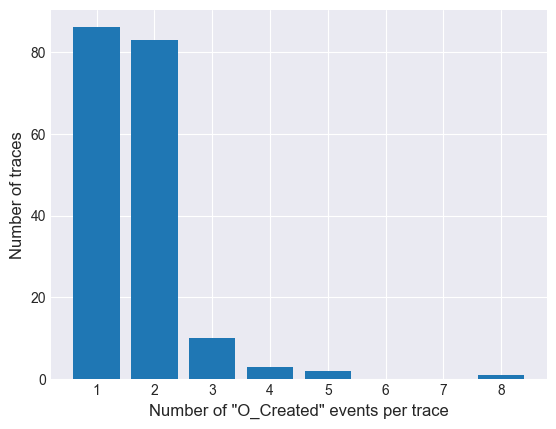

Text(0, 0.5, '% from the total "O_Cancelled" traces')

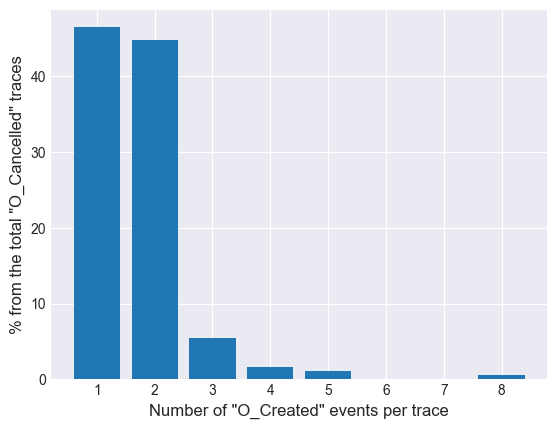

In [35]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.bar(x=list(mo_statistics.keys()), height=list(mo_statistics.values()), color='tab:blue');
plt.xlabel('Number of "O_Created" events per trace')
plt.ylabel('Number of traces')
plt.show()

plt.bar(x=list(mo_statistics_perc.keys()), height=list(mo_statistics_perc.values()), color='tab:blue');
plt.xlabel('Number of "O_Created" events per trace')
plt.ylabel('% from the total "O_Cancelled" traces')

# Local explanations 

In [54]:
from timeshap.explainer import local_pruning
from timeshap.wrappers import NextEventPredictorWrapper
from timeshap_customized_utils import calc_avg_event, calc_avg_sequence
from timeshap.plot.pruning import plot_temp_coalition_pruning
from timeshap.explainer.event_level import event_level
from timeshap.explainer.feature_level import feature_level
from timeshap.explainer.cell_level import cell_level
from timeshap_customized_utils import plot_event_heatmap, plot_feat_barplot
from dls import calculate_dls

In [111]:
# Fetch an explicand and prepare a model wrapper
explicand_ind = 0
explicand = o_cancelled_cases[explicand_ind]
print('Shape of the sequence to explain:',  explicand.shape)

wrapped_model = NextEventPredictorWrapper(model, batch_budget=1, categorical_indices=[0], 
                                          target='next_activity', device=torch.device('cpu'))
fetching_f = lambda x, hs=None: wrapped_model(sequences=x, hidden_state=hs)  # noqa: E731

Shape of the sequence to explain: (1, 95, 11)


In [112]:
explicand[:, :, 0]

array([[ 7., 11., 25., 25., 24.,  6., 24., 24.,  3., 15., 16., 15., 16.,
        19., 19., 24., 22., 22.,  5., 22., 22., 22., 15., 16., 14., 15.,
        16., 15., 16., 19., 19., 15., 16., 19., 22., 27., 27., 12., 18.,
        27., 23., 23.,  9., 23., 23., 23., 23., 27., 27., 12., 27., 27.,
        23., 23.,  9., 23., 23., 23., 23., 23., 23., 15., 16., 20., 23.,
        23., 23., 23., 27., 27., 12., 27., 27., 27., 27., 23., 23.,  9.,
        23., 23., 23., 23., 23., 15., 16., 20., 23.,  4., 14., 14., 14.,
        14., 14., 14., 14.]])

Preparing background data by sampling 100 instances from the training log

In [113]:
np.random.seed(RANDOM_SEED)
bc_data_ind = np.random.randint(0, 1000, size=100).tolist() 
print("Background data indices: ", bc_data_ind)
bc_data = [ ]
for ind in bc_data_ind:
    bc_trace = train_dataset[ind]
    bc_trace_arr = np.concatenate([bc_trace[0].numpy(), bc_trace[1].numpy()], axis=-1)
    bc_trace_arr = np.expand_dims(bc_trace_arr, axis=0)
    bc_data.append(bc_trace_arr)
    
max_length = max(list(map(lambda x: x[0].shape[0], bc_data)))
bc_data_padded = [np.pad(trace, mode='constant', pad_width=((0, 0), (0, max_length-trace.shape[1]), (0, 0))) for trace in bc_data]
bc_padded_array = np.concatenate(bc_data_padded, axis=0)
print('Padded background data shape for the calculation of an average event: ', bc_padded_array.shape)

Background data indices:  [102, 435, 860, 270, 106, 71, 700, 20, 614, 121, 466, 214, 330, 458, 87, 372, 99, 871, 663, 130, 661, 308, 769, 343, 491, 413, 805, 385, 191, 955, 276, 160, 459, 313, 21, 252, 747, 856, 560, 474, 58, 510, 681, 475, 699, 975, 782, 189, 957, 686, 957, 562, 875, 566, 243, 831, 504, 130, 484, 818, 646, 20, 840, 166, 273, 387, 600, 315, 13, 241, 776, 345, 564, 897, 339, 91, 366, 955, 454, 427, 508, 775, 942, 34, 205, 80, 931, 561, 871, 387, 1, 389, 565, 105, 771, 821, 476, 702, 401, 729]
Padded background data shape for the calculation of an average event:  (100, 88, 11)


Generating a baseline sequence and event

In [114]:
from timeshap.utils.utils import get_score_of_avg_sequence


cat_features_ind = [0]
num_features_ind = [i+1 for i, fname in enumerate(train_log.features.numerical)]
all_feature_names = list(train_log.features.categorical) + list(train_log.features.numerical)

avg_sequence = calc_avg_sequence(data=bc_padded_array, 
                           categorical_feats=cat_features_ind, 
                           numerical_feats=num_features_ind,
                           model_features=all_feature_names)
if len(avg_sequence.shape) == 2:
    avg_sequence = np.expand_dims(avg_sequence, axis=0)

print('Shape of the average sequence', avg_sequence.shape)
print('Average trace among the background data:\n', avg_sequence[:, :, 0])
print('Average sequence score: ', get_score_of_avg_sequence(fetching_f, data=avg_sequence)[0])

Shape of the average sequence (1, 88, 11)
Average trace among the background data:
 [[ 7. 11. 25. 25. 24.  6. 24. 24. 24. 24. 22.  5. 22. 22. 22. 22. 22. 22.
  22. 22. 22. 27. 22. 27. 27.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Average sequence score:  0.78976893


In [115]:
from timeshap.utils.utils import get_avg_score_with_avg_event


avg_event = calc_avg_event(data=avg_sequence[0, np.where(avg_sequence[:, :, 0]!=0)[1]], 
                            categorical_feats=cat_features_ind, 
                            numerical_feats=num_features_ind,
                            model_features=all_feature_names)
get_avg_score_with_avg_event(model=fetching_f, med=avg_event, top=5)

{1: 0.438777, 2: 0.49122, 3: 0.526613, 4: 0.549604, 5: 0.58405}

#### Generating a baseline sequence using Damerau-Levenstein Similarity

In [56]:
cohort_ind, cohort_sim = calculate_dls(subject_id=o_cancelled_ids[explicand_ind],
                                       subject_trace=explicand[0, :, 0],
                                       dataset=train_dataset, 
                                       vocabulary_size=len(train_log.vocabs[0]['activity']),
                                       threshold_similarity=0.7)

In [42]:
cohort_cases = []
for ind in cohort_ind:
    trace = train_dataset[ind]
    trace_arr = np.concatenate([trace[0].numpy(), trace[1].numpy()], axis=-1)
    cohort_cases.append(np.expand_dims(trace_arr, axis=0))

max_length = max(list(map(lambda x: x.shape[1], cohort_cases)))
cohort_data_padded = [np.pad(trace, mode='constant', pad_width=((0, 0), (0, max_length-trace.shape[1]), (0, 0))) for trace in cohort_cases]
cohort_array_padded = np.concatenate(cohort_data_padded, axis=0)
print('Padded cohort data shape for the calculation of an average sequence: ', cohort_array_padded.shape)
    

Padded cohort data shape for the calculation of an average sequence:  (804, 104, 11)


In [45]:
print('Cohort statistics')
print('Min trace length: ', min(list(map(lambda x: x.shape[1], cohort_cases))))
print('Max trace length: ', max(list(map(lambda x: x.shape[1], cohort_cases))))
print('Mean trace length: ', np.mean(list(map(lambda x: x.shape[1], cohort_cases))).round(2))


Cohort statistics
Min trace length:  11
Max trace length:  104
Mean trace length:  37.73


In [27]:
cohort_avg_sequence = calc_avg_sequence(data=cohort_array_padded, 
                           categorical_feats=cat_features_ind, 
                           numerical_feats=num_features_ind,
                           model_features=all_feature_names)
if len(avg_sequence.shape) == 2:
    cohort_avg_sequence = np.expand_dims(cohort_avg_sequence, axis=0)

print('Shape of the average sequence', cohort_avg_sequence.shape)
print('Average trace among the background data:\n', cohort_avg_sequence[:,0])
print('Average sequence score: ', get_score_of_avg_sequence(fetching_f, data=cohort_avg_sequence)[0])

Shape of the average sequence (104, 11)
Average trace among the background data:
 [ 7. 11. 25. 25. 24.  6. 24. 24. 24. 24. 24. 24. 22. 22. 22. 22. 22. 22.
 22. 22. 22. 27. 27. 27. 27. 27. 27.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Average sequence score:  0.92276925


### Prepare an explicand

In [116]:
from IPython.display import HTML

test_ds_id = o_cancelled_ids[explicand_ind]
trace_indices = list(test_dataset.traces[test_ds_id].numpy())
HTML(test_log.dataframe.iloc[trace_indices][['activity'] + NUMERICAL_FEATURES].reset_index(drop=True).iloc[::-1].reset_index(drop=True).to_html())

,activity,accumulated_time,day_of_month,day_of_week,day_of_year,hour_of_day,min_of_hour,month_of_year,sec_of_min,secs_within_day,week_of_year
0,23,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
1,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
2,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
3,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
4,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
5,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
6,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
7,14,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
8,4,3.463573,-1.195415,0.508947,-1.852828,0.991663,1.534421,-1.717241,-0.147594,1.112835,-1.837625
9,23,3.463507,-1.195415,0.508947,-1.852828,0.991663,1.477534,-1.717241,0.200993,1.108703,-1.837625


In [117]:
# The length of baseline sequence and the explicand shuld be the same
explicand_len = explicand.shape[1]
avg_seq_len = avg_sequence.shape[1]
adj_avg_sequence = copy.deepcopy(avg_sequence)

if avg_seq_len > explicand_len:
    adj_avg_sequence = adj_avg_sequence[:, :explicand_len, :]
elif avg_seq_len < explicand_len:
    adj_avg_sequence = np.pad(adj_avg_sequence, mode='constant', constant_values=0,
                              pad_width=((0, 0), (0, explicand_len-avg_seq_len), (0, 0)))

In [130]:
adj_avg_sequence[:, np.where(adj_avg_sequence[:, :, 0] == 0)[1], 0] = 27
adj_avg_sequence.shape

(1, 95, 11)

In [131]:
pruning_config = {'tol': 0.01}
pruning_result = local_pruning(f=fetching_f, data=explicand, 
                               pruning_dict=pruning_config, 
                               baseline=adj_avg_sequence,
                               verbose=True)

Allowed importance for pruned events: 0.01
len 0 | importance -0.3412053883075714
len -1 | importance -0.06082858145236969
len -2 | importance 0.08929400146007538
len -3 | importance -0.04135875403881073
len -4 | importance -0.181655153632164
len -5 | importance -0.4977009892463684
len -6 | importance -0.4192020893096924
len -7 | importance -0.3186967223882675
len -8 | importance -0.17215611040592194
len -9 | importance -0.06190948188304901
len -10 | importance -0.055401042103767395
len -11 | importance -0.017114654183387756
len -12 | importance -0.00874127447605133
len -13 | importance -0.0019336938858032227
len -14 | importance 0.004424303770065308
len -15 | importance 0.007702380418777466
len -16 | importance 0.008981376886367798
len -17 | importance 0.009214431047439575
len -18 | importance 0.006528124213218689
len -19 | importance 0.0053800493478775024
len -20 | importance 0.003979802131652832
len -21 | importance 0.004166319966316223
len -22 | importance 0.0038369297981262207
len

In [132]:
pruning_sv, pruning_ind = pruning_result
plot_temp_coalition_pruning(pruning_sv, pruned_idx=pruning_ind, 
                            solve_negatives=False, plot_limit=explicand_len)

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

### Event-level local explanation

In [133]:
# Due to the implementation, pruning algorithm consideres a sequence backwards, 
# which is not the case for other type of explanations .Thus, we compute in the last index of the pruned group
# by substracting the pruning index from the total sequence length
reverted_pruning_ind = explicand_len - abs(pruning_ind) if pruning_ind != -1 else 0 
reverted_pruning_ind

83

In [134]:
event_level_expl = event_level(f=fetching_f,
                               data=explicand, 
                               random_seed=RANDOM_SEED, 
                               nsamples=50000,
                               baseline=adj_avg_sequence, 
                               pruned_idx=reverted_pruning_ind)

In [135]:
explicand_trace = [train_log.vocabs[1]['activity'][int(event)] for i, event in enumerate(explicand[0, :, 0][::-1])]

In [136]:
event_level_expl

,Random seed,NSamples,Feature,Shapley Value
0,42,50000,Event -1,-0.090087
1,42,50000,Event -2,-0.099653
2,42,50000,Event -3,-0.097475
3,42,50000,Event -4,-0.028049
4,42,50000,Event -5,-0.036630
5,42,50000,Event -6,-0.007242
6,42,50000,Event -7,-0.002194
7,42,50000,Event -8,0.001859
8,42,50000,Event -9,0.006337
9,42,50000,Event -10,0.001009


In [137]:
event_level_expl['Feature'].values

array(['Event -1', 'Event -2', 'Event -3', 'Event -4', 'Event -5',
       'Event -6', 'Event -7', 'Event -8', 'Event -9', 'Event -10',
       'Event -11', 'Event -12', 'Pruned Events'], dtype=object)

In [138]:
explicand_trace = [train_log.vocabs[1]['activity'][int(event)] for i, event in enumerate(explicand[0, :, 0][::-1])]
new_names = [(': ').join([ev_id, ev_name]) if ev_id != 'Pruned Events' else 'Pruned Events' for ev_name, ev_id in zip(explicand_trace, event_level_expl['Feature'].values)]   
event_level_expl['Feature'] = new_names

In [139]:
import numpy as np
import pandas as pd
from scipy import stats
import copy
import re
import altair as alt
from timeshap.plot.utils import multi_plot_wrapper

from typing import Union, List, Optional, Tuple

def plot_event_heatmap(event_data: pd.DataFrame, plot_size: Tuple[int, int]):
    """Plots local event explanations

    Parameters
    ----------
    event_data: pd.DataFrame
        Event global explanations
    """
    event_data = copy.deepcopy(event_data)
    # extract digit to order df by - this is redundant but gives security to the method
    event_data["idx"] = event_data["Feature"].apply(
        lambda x: event_data.shape[0]
        if "Pruned Events" in x
        else int(re.findall(r"\d+", x)[0]) - 1
    )
    event_data = event_data.sort_values("idx")[["Shapley Value", "Feature"]]

    c_range = [
        "#5f8fd6",
        "#99c3fb",
        "#f5f5f5",
        "#ffaa92",
        "#d16f5b",
    ]

    event_data["row"] = event_data["Feature"].apply(
        lambda x: event_data.shape[0]
        if "Pruned Events" in x
        else -eval(x.split(":")[0][6:])
    )
    event_data["column"] = event_data["Feature"].apply(lambda x: 1)
    event_data["rounded"] = event_data["Shapley Value"].apply(lambda x: round(x, 3))
    event_data["rounded_str"] = event_data["Shapley Value"].apply(
        lambda x: "0.000" if round(x, 3) == 0 else str(round(x, 3))
    )
    event_data["rounded_str"] = event_data["rounded_str"].apply(
        lambda x: f"{x}0" if len(x) == 4 else x
    )

    c = alt.Chart().encode(
        y=alt.Y(
            "Feature:O",
            axis=alt.Axis(
                domain=False,
                labelFontSize=15,
                title="Event",
                titleFontSize=15,
                titleX=-49,
            ),
            sort=list(event_data["Feature"].values),
        ),
    )

    a = c.mark_rect().encode(
        x=alt.X("column:O", axis=alt.Axis(title="Shapley Value", titleFontSize=15)),
        color=alt.Color(
            "rounded",
            title=None,
            legend=alt.Legend(
                gradientLength=225,
                gradientThickness=10,
                orient="right",
                labelFontSize=15,
            ),
            scale=alt.Scale(domain=[event_data["Shapley Value"].min(), event_data["Shapley Value"].max()], range=c_range),
        ),
    )
    b = c.mark_text(
        align="right", baseline="middle", dx=18, fontSize=15, color="#798184"
    ).encode(
        x=alt.X(
            "column:O",
            axis=alt.Axis(labels=False, title="Shapley Value", domain=False, titleX=43),
        ),
        text="rounded_str",
    )

    event_plot = alt.layer(a, b, data=event_data).properties(
        width=plot_size[0], height=plot_size[1]
    )
    return event_plot

In [140]:
event_level_expl['Shapley Value'].min(), event_level_expl['Shapley Value'].max()

(-0.09965314496941631, 0.006336976808130446)

In [150]:
plot_event_heatmap(event_level_expl, plot_size=(150, 500))

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

### Feature-level explanations

In [142]:
from typing import cast, List

model_feats: List[int | str] = cast(List[int | str], ['activity'] + NUMERICAL_FEATURES)
feature_level_expl = feature_level(f=fetching_f, 
                                   data=explicand, 
                                   random_seed=RANDOM_SEED, 
                                   nsamples=50000,
                                   baseline=adj_avg_sequence, 
                                   pruned_idx=reverted_pruning_ind,
                                   model_feats=all_feature_names, 
                                   )
plot_feat_barplot(feature_level_expl, plot_size=(250, 300))

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [143]:
import altair as alt
import copy
import re
import math
from typing import Union, List, Optional, Tuple


def plot_cell_level(cell_data: pd.DataFrame,
                    model_features: List[str],
                    plot_features: Optional[dict] = None,
                    plot_parameters: Optional[dict] = None,
                    ):
    """Plots local feature explanations

    Parameters
    ----------
    cell_data: pd.DataFrame
        Cell level explanations

    model_features: int
        The number of feature to display.

    plot_features: dict
        Dict containing mapping between model features and display features

    plot_parameters: dict
        Dict containing optinal plot parameters
            'height': height of the plot, default 225
            'width': width of the plot, default 200
            'axis_lims': plot Y domain, default [-0.5, 0.5]
            'FontSize': plot font size, default 15
    """
    c_range = ["#5f8fd6",
               "#99c3fb",
               "#f5f5f5",
               "#ffaa92",
               "#d16f5b",
               ]
    # unique_events = [x for x in np.unique(cell_data['Event'].values) if x not in ['Other Events', 'Pruned Events']]
    # sort_events = sorted(unique_events, key=lambda x:  re.findall(r'\d+', x)[0], reverse=True)
    # unique_feats = [x for x in np.unique(cell_data['Feature'].values) if x not in ['Other Features', 'Pruned Events']]
    
    sort_events = cell_data.sort_index().drop_duplicates(subset='Event', keep='first')['Event'].tolist()
    unique_feats = model_feats
    if plot_features:
        plot_features = copy.deepcopy(plot_features)
        sort_features = [plot_features[x] for x in model_features if x in unique_feats]
        if 'Other Features' in np.unique(cell_data['Feature'].values):
            plot_features['Other Features'] = 'Other Features'

        if 'Pruned Events' in np.unique(cell_data['Feature'].values):
            plot_features['Pruned Events'] = 'Pruned Events'

        cell_data['Feature'] = cell_data['Feature'].apply(lambda x: plot_features[x])
    else:
        sort_features = [x for x in model_features if x in unique_feats]

    cell_data['rounded'] = cell_data['Shapley Value'].apply(lambda x: round(x, 3))
    cell_data['rounded_str'] = cell_data['Shapley Value'].apply(lambda x: '0.000' if round(x, 3) == 0 else str(round(x, 3)))
    cell_data['rounded_str'] = cell_data['rounded_str'].apply(lambda x: f'{x}0' if len(x) == 4 else x)

    filtered_cell_data = cell_data[~np.logical_and(cell_data['Event'] == 'Pruned Events', cell_data['Feature'] == 'Pruned Events')]

    if plot_parameters is None:
        plot_parameters = {}
    height = plot_parameters.get('height', 225)
    width = plot_parameters.get('width', 200)
    axis_lims = plot_parameters.get('axis_lim', [-.5, .5])
    fontsize = plot_parameters.get('FontSize', 15)

    c = alt.Chart().encode(
        y=alt.Y('Feature', axis=alt.Axis(domain=False, labelFontSize=fontsize, title=None), sort=sort_features),
    )

    a = c.mark_rect().encode(
        x=alt.X('Event', axis=alt.Axis(titleFontSize=15), sort=sort_events),
        color=alt.Color('rounded', title=None,
                        legend=alt.Legend(gradientLength=height,
                                          gradientThickness=10, orient='right',
                                          labelFontSize=fontsize),
                        scale=alt.Scale(domain=axis_lims, range=c_range))
    )
    b = c.mark_text(align='right', baseline='middle', dx=18, fontSize=15,
                    color='#798184').encode(
            x=alt.X('Event', sort=sort_events,
                    axis=alt.Axis(orient="top", title='Shapley Value', domain=False,
                                  titleY=height + 20, titleX=172, labelAngle=30,
                                  labelFontSize=fontsize, )),
            text='rounded_str',
    )

    cell_plot = alt.layer(a, b, data=filtered_cell_data).properties(
        width=math.ceil(0.8*width),
        height=height
    )

    if 'Pruned Events' in np.unique(cell_data['Event'].values):
        # isolate the pruned contribution
        df_prun = cell_data[np.logical_and(cell_data['Event'] == 'Pruned Events',cell_data['Feature'] == 'Pruned Events')]
        assert df_prun.shape == (1, 5)
        prun_rounded_str = df_prun.iloc[0]['rounded_str']
        prun_rounded = df_prun.iloc[0]['rounded']
        df_prun = pd.DataFrame([[["Pruned", "Events"], "Other features", prun_rounded, prun_rounded_str], ],
                               columns=['Event', 'Feature', 'rounded', 'rounded_str'])

        c = alt.Chart().encode(y=alt.Y('Feature',
                                       axis=alt.Axis(labels=False, domain=False,
                                                     title=None)), )

        a = c.mark_rect().encode(
            x=alt.X('Event', axis=alt.Axis(titleFontSize=fontsize)),
            color=alt.Color('rounded', title=None, legend=None,
                            scale=alt.Scale(domain=axis_lims, range=c_range))
        )
        b = c.mark_text(align='right', dx=18, baseline='middle', fontSize=fontsize,
                        color='#798184').encode(
            x=alt.X('Event',
                    axis=alt.Axis(labelOffset=24, labelPadding=30, orient="top",
                                  title=None, domain=False, labelAngle=0,
                                  labelFontSize=fontsize, )),
            text='rounded_str',
        )

        cell_plot_prun = alt.layer(a, b, data=df_prun).properties(
            width=width / 3,
            height=height
        )

        cell_plot = alt.hconcat(cell_plot_prun, cell_plot).resolve_scale(color='independent')
    return cell_plot

In [144]:
cell_config = {'top_x_events': 20, 'top_x_feats': 11}  # 'threshold': 0.01

cell_level_expl = cell_level(f=fetching_f, 
                             data=explicand, 
                             baseline=adj_avg_sequence,
                             event_data=event_level_expl, 
                             feat_data=feature_level_expl, 
                             random_seed=RANDOM_SEED, 
                             nsamples=50000, 
                             cell_dict=cell_config,
                             model_feats=model_feats, 
                             pruned_idx=reverted_pruning_ind)

In [145]:
cell_level_expl

,Event,Feature,Shapley Value
122,Event -1: O_Cancelled,accumulated_time,0.050786
131,Event -1: O_Cancelled,week_of_year,0.042357
115,Event -2: O_Cancelled,hour_of_day,0.018640
120,Event -2: O_Cancelled,week_of_year,0.017516
99,Event -3: O_Cancelled,activity,0.016176
...,...,...,...
130,Event -1: O_Cancelled,secs_within_day,-0.016203
100,Event -3: O_Cancelled,accumulated_time,-0.021978
128,Event -1: O_Cancelled,month_of_year,-0.032254
110,Event -2: O_Cancelled,activity,-0.036216


In [146]:
event_level_expl['Shapley Value'].min(), event_level_expl['Shapley Value'].max()

(-0.09965314496941631, 0.006336976808130446)

In [149]:
plot_cell_level(cell_level_expl, model_features=all_feature_names, 
                plot_parameters={'height': 400, 'width': 700,'FontSize': 9, 'axis_lims': [event_level_expl['Shapley Value'].min(),
                                                                                           event_level_expl['Shapley Value'].max()]})

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\sahat\a

alt.HConcatChart(...)

# Generate global explanations

In [73]:
from timeshap.explainer.pruning import prune_all, pruning_statistics
from timeshap.explainer.global_methods import event_explain_all, feat_explain_all
from timeshap.plot import plot_global_event, plot_global_feat


In [74]:
from typing import Callable, Union, Tuple, List
import numpy as np
import pandas as pd
import os
import csv
from pathlib import Path
from timeshap.utils import convert_to_indexes, convert_data_to_3d
from timeshap.explainer.event_level import verify_event_dict, local_event
from timeshap.explainer import temp_coalition_pruning
from timeshap.utils import get_tolerances_to_test


def event_explain_all(f: Callable,
                      data: Union[List[np.ndarray], pd.DataFrame, np.ndarray],
                      event_dict: dict,
                      pruning_data: pd.DataFrame = None,
                      baseline: Union[pd.DataFrame, np.array] = None,
                      model_features: List[Union[int, str]] = None,
                      schema: List[str] = None,
                      entity_col: Union[int, str] = None,
                      time_col: Union[int, str] = None,
                      append_to_files: bool = False,
                      verbose: bool = False,
                      ) -> pd.DataFrame:
    """Calculates event level explanations for all entities on the provided
    DataFrame applying pruning if explicit

    Parameters
    ----------
    f: Callable[[np.ndarray], np.ndarray]
        Point of entry for model being explained.
        This method receives a 3-D np.ndarray (#samples, #seq_len, #features).
        This method returns a 2-D np.ndarray (#samples, 1).

    data: Union[List[np.ndarray], pd.DataFrame, np.array]
        Sequences to be explained.
        Must contain columns with names disclosed on `model_features`.

    event_dict: dict
        Information required for the event level explanation calculation

    pruning_data: pd.DataFrame
        Pruning indexes for all sequences being explained.
        Produced by `prune_all`

    baseline: Union[np.ndarray, pd.DataFrame],
        Dataset baseline. Median/Mean of numerical features and mode of categorical.
        In case of np.array feature are assumed to be in order with `model_features`.
        The baseline can be an average event or an average sequence

    model_features: List[str]
        Features to be used by the model. Requires same order as training dataset

    schema: List[str]
        Schema of provided data

    entity_col: str
        Entity column to identify sequences

    time_col: str
        Data column that represents the time feature in order to sort sequences
        temporally

    append_to_files: bool
        Append explanations to files if file already exists

    verbose: bool
        If process is verbose

    Returns
    -------
    pd.DataFrame
    """
    if schema is None and isinstance(data, pd.DataFrame):
        schema = list(data.columns)
    verify_event_dict(event_dict)
    file_path = event_dict.get('path')
    make_predictions = True
    event_data = None

    tolerances_to_calc = get_tolerances_to_test(pruning_data, event_dict)

    if file_path is not None and os.path.exists(file_path):
        event_data = pd.read_csv(file_path)
        make_predictions = False

        present_tols = set(np.unique(event_data['Tolerance'].values))
        required_tols = [x for x in tolerances_to_calc if x not in present_tols]
        if len(required_tols) == 0:
            pass
        elif len(required_tols) == 1 and -1 in tolerances_to_calc:
            # Assuming all sequences are already explained
            make_predictions = True
        else:
            raise NotImplementedError
            # TODO resume explanations
            # conditions = []
            # necessary_entities = set(np.unique(data[entity_col].values))
            # event_data = pd.read_csv(file_path)
            # present_entities = set(np.unique(event_data[entity_col].values))
            # if necessary_entities.issubset(present_entities):
            #     conditions.append(True)
            #     event_data = event_data[event_data[entity_col].isin(necessary_entities)]
            #
            # necessary_tols = set(tolerances_to_calc)
            # loaded_csv = pd.read_csv(file_path)
            # present_tols = set(np.unique(loaded_csv['Tolerance'].values))
            # if necessary_tols.issubset(present_tols):
            #     conditions.append(True)
            #     event_data = event_data[event_data['Tolerance'].isin(necessary_tols)]
            #
            # make_predictions = ~np.array(conditions).all()

    if make_predictions:
        random_seeds = list(np.unique(event_dict.get('rs')))
        nsamples = list(np.unique(event_dict.get('nsamples')))
        names = ["Random Seed", "NSamples", "Event", "Shapley Value", "t (event index)", "Entity", 'Tolerance']

        if file_path is not None:
            if os.path.exists(file_path):
                assert append_to_files, "The defined path for event explanations already exists and the append option is turned off. If you wish to append the explanations please use the flag `append_to_files`, otherwise change the provided path."
            else:
                if '/' in file_path:
                    Path(file_path.rsplit("/", 1)[0]).mkdir(parents=True, exist_ok=True)
                with open(file_path, 'w', newline='') as file:
                    writer = csv.writer(file, delimiter=',')
                    writer.writerow(names)

        if time_col is None:
            print("No time col provided, assuming dataset is ordered ascendingly by date")

        model_features_index, entity_col_index, time_col_index = convert_to_indexes(model_features, schema, entity_col, time_col)
        data = convert_data_to_3d(data, entity_col_index, time_col_index)

        ret_event_data = []
        for rs in random_seeds:
            for ns in nsamples:
                for i, sequence in enumerate(data):
                    if entity_col is not None:
                        entity = sequence[0, 0, entity_col_index]
                    else:
                        entity = i
                    if model_features:
                        sequence = sequence[:, :, model_features_index]
                    sequence = sequence.astype(np.float64)
                    event_data = None
                    prev_pruning_idx = None
                    for tol in tolerances_to_calc:
                        if tol == -1:
                            pruning_idx = 0
                        elif pruning_data is None:
                            #we need to perform the pruning on the fly
                            coal_prun_idx, _ = temp_coalition_pruning(f, sequence, baseline, tol)
                            pruning_idx = data.shape[1] + coal_prun_idx
                        else:
                            instance = pruning_data[pruning_data["Entity"] == entity]
                            pruning_idx = instance[instance['Tolerance'] == tol]['Pruning idx'].iloc[0]
                            pruning_idx = sequence.shape[1] + pruning_idx
                            print('prunning_idx:', pruning_idx, 'seq length:', sequence.shape[1])

                        if prev_pruning_idx == pruning_idx:
                            # we have already calculated this, let's use it from the last iteration
                            event_data['Tolerance'] = tol
                        else:
                            local_event_dict = {'rs': rs, 'nsamples': ns}
                            event_data = local_event(f, sequence, local_event_dict, entity, entity_col, baseline, pruning_idx)
                            event_data['Event index'] = event_data['Feature'].apply(lambda x: 1 if x == 'Pruned Events' else -int(re.findall(r'\d+', x)[0])+1)
                            event_data[entity_col] = entity
                            event_data['Tolerance'] = tol

                        if file_path is not None:
                            with open(file_path, 'a', newline='') as file:
                                writer = csv.writer(file, delimiter=',')
                                writer.writerows(event_data.values)
                        ret_event_data.append(event_data.values)
                        prev_pruning_idx = pruning_idx

        event_data = pd.DataFrame(np.concatenate(ret_event_data), columns=names)
        event_data = event_data.astype({'NSamples': 'int', 'Random Seed': 'int', 'Tolerance': 'float', 'Shapley Value': 'float', 't (event index)': 'int'})
    return event_data


In [ ]:
# adj_avg_sequences = []
# for event in o_cancelled_cases:
#     if avg_seq_len > event.shape[1]:
#         temp_avg_sequence = avg_sequence[:, :event.shape[1], :]
#     elif avg_seq_len < event.shape[1]:
#         temp_avg_sequence = np.pad(avg_sequence, mode='edge',
#                                 pad_width=((0, 0), (0, explicand_len-avg_seq_len), (0, 0)))
#     adj_avg_sequences.append(temp_avg_sequence)


(1, 50, 11)

In [83]:
global_pruning_result = prune_all(f=fetching_f, 
                                  data=o_cancelled_cases, 
                                  baseline=avg_event,
                                  pruning_dict={'tol': 0.01})

No time col provided, assuming dataset is ordered ascendingly by date


In [48]:
pruning_config = {'tol': 0.01}
pruning_result_2 = local_pruning(f=fetching_f, data=o_cancelled_cases[30], 
                               pruning_dict=pruning_config, 
                               baseline=avg_sequence[:, :o_cancelled_cases[30].shape[1], :],
                               verbose=True)

pruning_result_2

Allowed importance for pruned events: 0.01
len 0 | importance -0.6421294957399368
len -1 | importance -0.45713216066360474
len -2 | importance -0.2801293730735779
len -3 | importance -0.3903888761997223
len -4 | importance -0.2769344449043274
len -5 | importance -0.24918586015701294
len -6 | importance -0.20714202523231506
len -7 | importance -0.14903610944747925
len -8 | importance -0.1249830424785614
len -9 | importance -0.0961976945400238
len -10 | importance -0.05219826102256775
len -11 | importance -0.026370331645011902
len -12 | importance -0.037664711475372314
len -13 | importance -0.00847102701663971
len -14 | importance 0.012151017785072327
len -15 | importance 0.02749970555305481
len -16 | importance 0.023993462324142456
len -17 | importance 0.031647562980651855
len -18 | importance 0.02801421284675598
len -19 | importance 0.018296480178833008
len -20 | importance 0.00846967101097107
len -21 | importance 0.018860623240470886
len -22 | importance 1.4901161193847656e-08


(                            Coalition  t (event index)  Shapley Value
 0   Sum of contribution of events > t                0   1.490116e-08
 1   Sum of contribution of events ≤ t                0  -6.421295e-01
 2   Sum of contribution of events > t               -1  -1.849973e-01
 3   Sum of contribution of events ≤ t               -1  -4.571322e-01
 4   Sum of contribution of events > t               -2  -3.620001e-01
 5   Sum of contribution of events ≤ t               -2  -2.801294e-01
 6   Sum of contribution of events > t               -3  -2.517406e-01
 7   Sum of contribution of events ≤ t               -3  -3.903889e-01
 8   Sum of contribution of events > t               -4  -3.651950e-01
 9   Sum of contribution of events ≤ t               -4  -2.769344e-01
 10  Sum of contribution of events > t               -5  -3.929436e-01
 11  Sum of contribution of events ≤ t               -5  -2.491859e-01
 12  Sum of contribution of events > t               -6  -4.349875e-01
 13  S

In [71]:
global_pruning_result[global_pruning_result['Entity'] == 30].iloc[[1], :]['Pruning idx'] = -13.0

In [72]:
global_pruning_result

,Entity,Tolerance,Pruning idx
0,0,-1.00,-95.0
1,0,0.01,-12.0
2,1,-1.00,-50.0
3,1,0.01,-19.0
4,2,-1.00,-27.0
...,...,...,...
365,182,0.01,-7.0
366,183,-1.00,-21.0
367,183,0.01,-12.0
368,184,-1.00,-17.0


In [87]:
event_data = event_explain_all(f=fetching_f, 
                               data=o_cancelled_cases[:30], 
                               baseline=avg_event,
                               pruning_data=global_pruning_result[:60],
                               event_dict={'rs': RANDOM_SEED, 'nsamples': 50000},
                               verbose=True)

No time col provided, assuming dataset is ordered ascendingly by date
prunning_idx: 83.0 seq length: 95
prunning_idx: 31.0 seq length: 50
prunning_idx: 11.0 seq length: 27
prunning_idx: 12.0 seq length: 19
prunning_idx: 33.0 seq length: 47
prunning_idx: 16.0 seq length: 31
prunning_idx: 92.0 seq length: 97
prunning_idx: 21.0 seq length: 22
prunning_idx: 17.0 seq length: 29
prunning_idx: 14.0 seq length: 20
prunning_idx: 20.0 seq length: 31
prunning_idx: 14.0 seq length: 26
prunning_idx: 18.0 seq length: 33
prunning_idx: 57.0 seq length: 70
prunning_idx: 8.0 seq length: 21
prunning_idx: 7.0 seq length: 23
prunning_idx: 19.0 seq length: 21
prunning_idx: 21.0 seq length: 34
prunning_idx: 22.0 seq length: 25
prunning_idx: 16.0 seq length: 24
prunning_idx: 9.0 seq length: 24
prunning_idx: 31.0 seq length: 50
prunning_idx: 17.0 seq length: 23
prunning_idx: 30.0 seq length: 48
prunning_idx: 24.0 seq length: 40
prunning_idx: 72.0 seq length: 75
prunning_idx: 17.0 seq length: 22
prunning_idx: 1

In [105]:
event_data

,Random Seed,NSamples,Event,Shapley Value,t (event index),Entity,Tolerance
0,42,50000,Event -1,-0.185137,0,0,0.01
1,42,50000,Event -2,0.006738,-1,0,0.01
2,42,50000,Event -3,0.025834,-2,0,0.01
3,42,50000,Event -4,0.034139,-3,0,0.01
4,42,50000,Event -5,0.017573,-4,0,0.01
...,...,...,...,...,...,...,...
367,42,50000,Event -17,-0.002891,-16,29,0.01
368,42,50000,Event -18,-0.003622,-17,29,0.01
369,42,50000,Event -19,-0.002481,-18,29,0.01
370,42,50000,Event -20,-0.003327,-19,29,0.01


In [88]:
plot_global_event(event_data, plot_parameters={'height': 300, 'width': 600})

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [93]:
from timeshap.explainer.feature_level import verify_feature_dict, local_feat

def feat_explain_all(f: Callable,
                     data: Union[List[np.ndarray], pd.DataFrame, np.ndarray],
                     feat_dict: dict,
                     pruning_data: pd.DataFrame,
                     baseline: Union[pd.DataFrame, np.ndarray] = None,
                     model_features: List[Union[int, str]] = None,
                     schema: List[str] = None,
                     entity_col: Union[int, str] = None,
                     time_col: Union[int, str] = None,
                     append_to_files: bool = False,
                     verbose: bool = False,
                     ) -> pd.DataFrame:
    """Calculates event level explanations for all entities on the provided
    DataFrame applying pruning if explicit

    Parameters
    ----------
    f: Callable[[np.ndarray], np.ndarray]
        Point of entry for model being explained.
        This method receives a 3-D np.ndarray (#samples, #seq_len, #features).
        This method returns a 2-D np.ndarray (#samples, 1).

    data: Union[List[np.ndarray], pd.DataFrame, np.array]
        Sequences to be explained.
        Must contain columns with names disclosed on `model_features`.

    feat_dict: dict
        Information required for the feature level explanation calculation

    entity_col: str
        Entity column to identify sequences

    pruning_data: pd.DataFrame
        Pruning indexes for all sequences being explained.
        Produced by `prune_all`

    baseline: Union[np.ndarray, pd.DataFrame],
        Dataset baseline. Median/Mean of numerical features and mode of categorical.
        In case of np.array feature are assumed to be in order with `model_features`.
        The baseline can be an average event or an average sequence

    model_features: List[str]
        Features to be used by the model. Requires same order as training dataset

    schema: List[str]
        Schema of provided data

    entity_col: str
        Entity column to identify sequences

    time_col: str
        Data column that represents the time feature in order to sort sequences
        temporally

    append_to_files: bool
        Append explanations to files if file already exists

    verbose: bool
        If process is verbose

    Returns
    -------
    pd.DataFrame
    """
    if schema is None and isinstance(data, pd.DataFrame):
        schema = list(data.columns)
    verify_feature_dict(feat_dict)
    file_path = feat_dict.get('path')
    make_predictions = True
    feat_data = None

    tolerances_to_calc = get_tolerances_to_test(pruning_data, feat_dict)

    if file_path is not None and os.path.exists(file_path):
        feat_data = pd.read_csv(file_path)
        make_predictions = False

        present_tols = set(np.unique(feat_data['Tolerance'].values))
        required_tols = [x for x in tolerances_to_calc if x not in present_tols]
        if len(required_tols) == 0:
            pass
        elif len(required_tols) == 1 and -1 in tolerances_to_calc:
            # Assuming all sequences are already explained
            make_predictions = True
        else:
            raise NotImplementedError

            # TODO resume explanations
            # conditions = []
            # necessary_entities = set(np.unique(data[entity_col].values))
            # feat_data = pd.read_csv(file_path)
            # present_entities = set(np.unique(feat_data[entity_col].values))
            # if necessary_entities.issubset(present_entities):
            #     conditions.append(True)
            #     feat_data = feat_data[feat_data[entity_col].isin(necessary_entities)]
            #
            # necessary_tols = set(tolerances_to_calc)
            # loaded_csv = pd.read_csv(file_path)
            # present_tols = set(np.unique(loaded_csv['Tolerance'].values))
            # if necessary_tols.issubset(present_tols):
            #     conditions.append(True)
            #     feat_data = feat_data[loaded_csv['Tolerance'].isin(necessary_tols)]
            #
            # make_predictions = ~np.array(conditions).all()

    if make_predictions:
        random_seeds = list(np.unique(feat_dict.get('rs')))
        nsamples = list(np.unique(feat_dict.get('nsamples')))
        names = ["Random Seed", "NSamples", "Feature",  "Shapley Value", "Entity", 'Tolerance']

        if file_path is not None:
            if os.path.exists(file_path):
                assert append_to_files, "The defined path for event explanations already exists and the append option is turned off. If you wish to append the explanations please use the flag `append_to_files`, otherwise change the provided path."
            else:
                if '/' in file_path:
                    Path(file_path.rsplit("/", 1)[0]).mkdir(parents=True, exist_ok=True)
                with open(file_path, 'w', newline='') as file:
                    writer = csv.writer(file, delimiter=',')
                    writer.writerow(names)

        if time_col is None:
            print("No time col provided, assuming dataset is ordered ascendingly by date")

        model_features_index, entity_col_index, time_col_index = convert_to_indexes(model_features, schema, entity_col, time_col)
        data = convert_data_to_3d(data, entity_col_index, time_col_index)

        ret_feat_data = []
        for rs in random_seeds:
            for ns in nsamples:
                for i, sequence in enumerate(data):
                    if entity_col is not None:
                        entity = sequence[0, 0, entity_col_index]
                    else:
                        entity = i 
                    if model_features:
                        sequence = sequence[:, :, model_features_index]
                    sequence = sequence.astype(np.float64)
                    feat_data = None
                    prev_pruning_idx = None
                    for tol in tolerances_to_calc:
                        if tol == -1:
                            pruning_idx = 0
                        elif pruning_data is None:
                            #we need to perform the pruning on the fly
                            coal_prun_idx, _ = temp_coalition_pruning(f, sequence, baseline, tol)
                            pruning_idx = data.shape[1] + coal_prun_idx
                        else:
                            instance = pruning_data[pruning_data["Entity"] == entity]
                            pruning_idx = instance[instance['Tolerance'] == tol]['Pruning idx'].iloc[0]
                            pruning_idx = sequence.shape[1] + pruning_idx

                        if prev_pruning_idx == pruning_idx:
                            # we have already calculated this, let's use it from the last iteration
                            feat_data['Tolerance'] = tol
                        else:
                            local_feat_dict = {'rs': rs, 'nsamples': ns}
                            if feat_dict.get('feature_names'):
                                local_feat_dict['feature_names'] = feat_dict.get('feature_names')
                            feat_data = local_feat(f, sequence, local_feat_dict, entity, entity_col, baseline, pruning_idx)
                            feat_data[entity_col] = entity
                            feat_data['Tolerance'] = tol

                        if file_path is not None:
                            with open(file_path, 'a', newline='') as file:
                                writer = csv.writer(file, delimiter=',')
                                writer.writerows(feat_data.values)
                        ret_feat_data.append(feat_data.values)
                        prev_pruning_idx = pruning_idx

        feat_data = pd.DataFrame(np.concatenate(ret_feat_data), columns=names)
        feat_data = feat_data.astype({'NSamples': 'int', 'Random Seed': 'int', 'Tolerance': 'float', 'Shapley Value': 'float'})
    return feat_data

In [96]:
global_feat_expl = feat_explain_all(f=fetching_f, 
                                    data=o_cancelled_cases[:30], 
                                    baseline=avg_event,
                                    pruning_data=global_pruning_result[:60],
                                    feat_dict={'rs': RANDOM_SEED, 'nsamples': 50000},
                                    # model_features=all_feature_names,
                                    verbose=True)

No time col provided, assuming dataset is ordered ascendingly by date


In [98]:
global_feat_expl

,Random Seed,NSamples,Feature,Shapley Value,Entity,Tolerance
0,42,50000,Feature 0,-0.085893,0,0.01
1,42,50000,Feature 1,0.016314,0,0.01
2,42,50000,Feature 2,-0.002520,0,0.01
3,42,50000,Feature 3,-0.005234,0,0.01
4,42,50000,Feature 4,0.107301,0,0.01
...,...,...,...,...,...,...
355,42,50000,Feature 7,0.027575,29,0.01
356,42,50000,Feature 8,-0.016461,29,0.01
357,42,50000,Feature 9,-0.031242,29,0.01
358,42,50000,Feature 10,-0.054656,29,0.01


In [103]:
features_mapping = {f'Feature {i}': fname for i, fname in enumerate(all_feature_names)}

In [104]:
plot_global_feat(global_feat_expl, plot_parameters={'height': 300, 'width': 600}, top_x_feats=15, 
                 plot_features=features_mapping)

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)